# Matching

## Описание проекта

**Matching** - это задача поиска и сопоставления двух объектов из разных наборов данных. В данной работе необходимо решить проблему сопоставления товаров для маркетплейса. Маркетблейс имеет огромный перечень товаров для продажи. На склад стали поступать новые партии товаров, которые имеет небольшие отличия в характеристиках. Технически, это выглядит как совершенно новые товары. Фактически это те же товары, которые уже продаются на маркетплейсе. Цель работы заключается в создании модели для сопоставления и связи новых товаров со старыми, пользуясь совпадающими характеристиками.

**Что надо сделать?**
- разработать алгоритм, который для всех товаров из _validation.csv_ предложит несколько вариантов наиболее похожих товаров из base;
- оценить качество алгоритма по метрике `accuracy@5`.

$$
accuracy@n = \frac{\text{кол-во верных соотношений (из n кандидатов)}} {\text{n (общее кол-во кандидатов)}} * 100\%
$$

Именно в _предложении 5 кандидатов_ для соотношения и заключается отличительная черта данной метрики.

**Данные:** [источник](https://disk.yandex.ru/d/BBEphK0EHSJ5Jw)

- *base.csv* - анонимизированный набор товаров. Каждый товар представлен как уникальный **id** (`0-base, 1-base, 2-base, …`) и вектор признаков размерностью 72.
- *train.csv -* обучающий датасет. Каждая строчка - один товар, для которого известен уникальный **id** (`0-query, 1-query, …`) , вектор признаков И id товара из *base.csv*, который максимально похож на него (по мнению экспертов).
- *validation.csv* - датасет с товарами (уникальный **id** и вектор признаков), для которых надо найти наиболее близкие товары из *base.csv*
- *validation_answer.csv* - правильные ответы к предыдущему файлу.

**План работы:**
- Загрузить данные
- Провести предобработку и подготовку данных
- Обучить модель (поиск ближайших соседей + ранжирование)
- Измерить качество модели по выбранной метрике
- Сделать основные выводы



## Подготовка данных

Загрузка основных библиотек.

В этом проекте будет использована библиотека для кластеризации [Faiss](https://faiss.ai/index.html).

In [58]:
# FAISS.
!pip install faiss-cpu==1.7.4
import faiss



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [59]:
faiss.__version__

'1.7.4'

In [60]:
# ANNOY.
!pip install annoy -q
from annoy import AnnoyIndex


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [87]:
# импорт библиотек
import gc
import phik
import faiss
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# импорт спец. модулей
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from phik import resources, report
from phik.report import plot_correlation_matrix

# константы
RANDOM_STATE = 42  # фиксация случайности
N_CLUSTERS   = 200 # кол-во кластеров для деления векторного пространства
K_NEIGHBORS  = 30  # кол-во ближайших соседей
N_CELLS      = 5   # конечное кол-во кандидатов на сопоставление
# Установим начальное значение генератора псевдослучайных чисел.
SEED = 42
np.random.seed(SEED)
DATA_DIR = 'C:\Python\Data science\Master2\data/'

In [62]:
# Установим стиль отображения заголовков таблиц.
styles = [
    dict(selector='caption',
         props=[('text-align', 'center'),
                ('font-size', '110%'),
                ('font-weight', 'bold'),
                ('white-space', 'pre-wrap')]),
    dict(selector="th",
         props=[('max-width', '250px')])
    ]

# Установим отображение всех столбцов при выводе датафрейма.
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Игнорируем FutureWarning от Pandas.
from warnings import simplefilter
simplefilter(action='ignore', category=Warning)

# Установим стиль отображения заголовков таблиц.
styles = [
    dict(selector='caption',
         props=[('text-align', 'center'),
                ('font-size', '110%'),
                ('font-weight', 'bold'),
                ('white-space', 'pre-wrap')]),
    dict(selector="th",
         props=[('max-width', '250px')])
    ]

# Установим отображение всех столбцов при выводе датафрейма.
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Игнорируем FutureWarning от Pandas.
from warnings import simplefilter
simplefilter(action='ignore', category=Warning)

In [63]:
%%time
# чтение датасетов
base_df       = pd.read_csv(DATA_DIR + 'base.csv')
train_df      = pd.read_csv(DATA_DIR + 'train.csv')
valid_df      = pd.read_csv(DATA_DIR + 'validation.csv')
valid_targets = pd.read_csv(DATA_DIR + 'validation_answer.csv')

Wall time: 57.1 s


In [64]:
# Оптимизация числовых типов данных

def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    
    '''
    Function optimizes memory usage in dataframe
    print_size: bool - display of optimization results
    return pd.DataFrame - amount of optimized memory
    '''

    # Типы, которые будем проверять на оптимизацию
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2    
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)  
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)

    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1%})'
                        .format(before_size, after_size, (before_size - after_size) / before_size))

    return df

Необходимо привести названия колонок к нижнему регистру и назначить индексацию **id** товаров, а так же оптимизировать объём памяти, занимаемый данными.

In [65]:
# стандартизация названий колонок, смена индексации и оптимизации объёма данных
for df in [base_df, train_df, valid_df, valid_targets]:
    df.columns = df.columns.str.lower()
    df.set_index('id', inplace=True)
    df = optimize_memory_usage(df)
del df

Размер использования памяти: до 1625.25 Mb - после 823.75 Mb (49.3%)
Размер использования памяти: до 56.46 Mb - после 28.99 Mb (48.6%)
Размер использования памяти: до 55.69 Mb - после 28.23 Mb (49.3%)
Размер использования памяти: до  1.53 Mb - после  1.53 Mb (0.0%)


## Анализ данных

### Base

`Base` - набор из всех товаров (когда либо продававшихся на маркетплейсе) и 72 колонки с их характеристиками. Фактическое значение этих характеристик не имеет значения в рамках этого проекта. Эти данные прошли предварительную обработку (анонимизацию). 

In [66]:
%%time
display(base_df.head())
print(base_df.info(verbose=True, show_counts=True))


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083893,11.152912,-64.426758,-118.880890,216.482437,-104.698059,-469.070587,44.348083,120.915344,181.449707,-124.061508,-32.458237,-57.420559,36.207405,182.716766,-28.071688,-5.209374,-1.732183,-91.091858,-79.466667,-103.939087,1507.231323,-32.591667,51.414360,-51.905361,813.770081,-41.556538,8.419807,-129.976639,148.765030,-10.069234,-143.005035,79.848694,-537.183716,2.773180,111.518677,4.257666,-153.340576,-123.626083,-39.707664,-12.768708,-4.170106,-152.967133,75.911522,-57.470089,17.266476,-98.871155,-138.067535,91.000381,-170.701996,-50.020390,59.794296,78.106377,-89.375725,89.412102,79.812180,-129.513611,-44.659496,-80.442207,5.149714,-64.518951,-138.777634,-42.808693,38.800827,-151.762177,-74.389091,63.666340,-4.703861,92.933609,115.269188,-112.756638,-60.830353
1-base,-34.562202,13.332763,-69.787613,-166.533478,57.680607,-86.098373,-85.076668,-35.637436,119.718636,195.234192,-141.304352,-126.768898,-68.853531,8.314717,143.081741,8.778257,15.157185,48.246361,-244.954865,-80.279419,-81.788040,429.880035,-5.937690,70.142654,66.576843,813.770081,3.214371,17.164303,-39.418385,148.155884,-7.579590,-174.369949,101.224632,-303.939240,16.914631,53.394676,33.451824,-148.552628,-110.340172,-33.277206,-8.688703,13.650302,-91.228745,38.445015,-31.948471,62.484821,-166.473358,-189.010422,-56.731556,-30.027319,59.171059,-56.711540,63.542606,-121.319168,97.426056,74.832840,-138.777054,58.887608,-71.595337,-251.952362,11.392853,-148.571655,-117.767525,41.099998,-157.829407,-94.446808,68.202110,24.346846,179.937927,116.834000,-84.888939,-59.524609
2-base,-54.233746,6.379371,-29.210136,-133.413834,150.895828,-99.435326,52.554794,62.381706,128.951447,164.381470,-140.822449,-22.486748,-51.666988,2.521726,140.585449,-22.039230,-7.128633,-5.184787,-111.712120,-79.029266,-82.452576,1507.231323,-0.421011,84.108009,63.344509,813.770081,-105.211052,18.844700,-94.789474,151.387711,-21.483440,-144.845367,48.502934,-780.449158,64.767311,79.781555,-13.390142,-150.061661,-118.758553,-40.896286,-15.222620,-1.860338,-93.820656,98.749069,-46.745781,65.927475,-10.286392,-125.321373,21.048609,-22.637775,68.915985,-54.902260,66.335472,-142.927917,83.030983,69.979630,-123.733887,65.320877,-114.037178,-529.396973,-101.581375,-134.658218,-76.397797,46.011803,-207.144424,127.325569,65.566177,66.325684,81.073486,116.594154,-1074.464844,-32.527206
3-base,-87.520126,4.037884,-87.803032,-185.067627,76.369537,-58.985165,-383.182831,-33.611237,122.031914,136.233582,-108.470444,-104.537781,-82.388489,-79.986740,113.596313,-38.995880,-4.787360,8.327808,-124.855759,-79.109016,-107.943275,1479.170532,-125.271614,24.656485,-16.921055,813.770081,-182.680267,14.715704,-62.932701,151.201981,10.613454,-134.934341,58.777729,-529.295044,43.665924,92.806305,-38.936657,-145.045303,-124.295769,-36.876732,-17.742870,10.536242,-124.584152,121.914146,-17.321358,105.217239,-94.379646,-63.769272,29.217487,-26.423973,5.869829,64.061546,63.513279,-112.258102,80.926590,72.636101,-137.314316,7.912551,-62.188919,-540.321045,-89.588715,-149.326691,-70.647942,-6.358921,-147.201050,-37.692749,66.202888,-20.566910,137.206940,117.474098,-1074.464844,-72.915489
4-base,-72.743851,6.522048,43.671265,-140.608032,5.820023,-112.074081,-397.711273,45.182499,122.167183,112.119064,-110.342453,-38.982059,-50.228867,-26.690920,135.272903,-7.510103,8.924209,111.576950,-130.833191,-79.315849,-57.843952,1262.919678,19.225910,59.811813,76.159668,312.698914,-76.726974,21.299923,-24.069107,167.385529,-44.059471,-148.131851,98.042610,-657.524414,96.363167,71.061523,-36.563557,-135.372437,-123.708977,-44.739437,-10.855220,8.354800,-168.328857,215.928070,-32.975979,66.864883,30.838631,-211.540375,57.695343,-67.822632,-29.38913

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   0       2918139 non-null  float32
 1   1       2918139 non-null  float32
 2   2       2918139 non-null  float32
 3   3       2918139 non-null  float32
 4   4       2918139 non-null  float32
 5   5       2918139 non-null  float32
 6   6       2918139 non-null  float32
 7   7       2918139 non-null  float32
 8   8       2918139 non-null  float32
 9   9       2918139 non-null  float32
 10  10      2918139 non-null  float32
 11  11      2918139 non-null  float32
 12  12      2918139 non-null  float32
 13  13      2918139 non-null  float32
 14  14      2918139 non-null  float32
 15  15      2918139 non-null  float32
 16  16      2918139 non-null  float32
 17  17      2918139 non-null  float32
 18  18      2918139 non-null  float32
 19  19      2918139 non-null  float32
 20  20      2918139 non

In [67]:
print('Кол-во товаров-дубликатов:', base_df.duplicated().sum())

Кол-во товаров-дубликатов: 0


Выведем функцию расчета процента выбросов.

In [68]:
def get_outliers_ratio(col: pd.Series, whiskers=False, iqr_coeff=1.5):
    '''
    Calculates boxplot whiskers and outlier percentage. Optionaly returns
    whiskers.
    Arguments:
    - data: pd.DataFrame() | pd.Series(). Either DataFrame or Series variable.
    - whiskers: bool. whether to return whiskers (True) or not.
    - coeff: float. Default - 1.5 for 2.7 sigma. Can be changed to 1.7 for
      3 sigma.
    '''
    # Вычислим интерквартильный размах.
    distr_iqr = col.quantile(.75) - col.quantile(.25)
    # Вычислим границы.
    whisker_upp = col.quantile(.75) + iqr_coeff * distr_iqr
    whisker_low = col.quantile(.25) - iqr_coeff * distr_iqr
    # Если усы границы экстремумы, приравняем их.
    if whisker_upp >= col.max():
        whisker_upp = col.max()
    if whisker_low <= col.min():
        whisker_low = col.min()
    else:
        pass
    # Вычислим процент выбросов.
    outliers_ratio = (
        (col[col > whisker_upp].count() +
         col[col < whisker_low].count()) /
        len(col)
        )
    # Выведем границы и процент выбросов если необходимо.
    if whiskers:
        return whisker_low, whisker_upp, outliers_ratio
    # Выведем только процент выбросов.
    else:
        return outliers_ratio

#### Функция вывода графиков ИАД.
- Функция примет
  - датафрейм;
  - опционально:
    - название датайрейма;
    - процент подвыборки;
    - метку вывода процентов выбросов;
    - коэффициент для рассчёта выбросов;
- Функция выведет гистограммы и диаграммы размаха для всех признаков датафрейма.

In [69]:
# Функция вывода графиков ИАД.
def get_eda_plots(df : pd.DataFrame, name = None,
                  sample_frac = None, seed = SEED,
                  outliers = True, iqr_coeff = 1.5):
    '''
    Plots histograms and boxplot diagrams for all features of a
    dataframe with sampling if required.
    Arguments:
    - df: pd.DataFrame;
    - name: str. Dataframe name;
    - sample: Bool. Whether sampling is required;
    - sample_frac: float. sampling fraction;
    - seed: random state seed for sampling;
    - outliers: Bool. Whether to show outlier percentage.
    - iqr_coeff: float. Coefficient for whiskers calculation.
      Mainly to choose from
      - 1.5 for 2.7 sigma;
      - 1.7 for 3 sigma.
    '''

    # Проверим необходимость сэмплирования.
    if sample_frac:
        df_to_plot = df.sample(frac=sample_frac, random_state=seed)
        sample_t = f' {sample_frac:.0%} выборки'
    else:
        df_to_plot = df
        sample_t = ''
    # Проверим указание названия датафрейма.
    name = f' датафрейма "{name}"' if name else ''

    # Выведем гистограммы.
    axs = df_to_plot.hist(figsize=[20, 20], bins=50)
    if outliers:
        for ax, col in zip(axs.flatten(), df_to_plot.columns):
            outlier_perc = get_outliers_ratio(df[col], iqr_coeff=iqr_coeff)
            ax.set_title(f'Признак "{col}".\nВыбросов: '+
                         f'{outlier_perc:.1%}')
    plt.suptitle('Гистограммы' + sample_t + name + '.', y=.99, fontsize=16)
    plt.tight_layout()
    plt.show();

    # Выведем диаграммы размаха.
    df_to_plot.plot(kind='box', grid=True, figsize=[20, 8])
    plt.title('Диаграммы размаха'  + sample_t + name + '.', fontsize=16)
    plt.tight_layout()
    plt.show();

Вызовем функцию и выведем графики для репрезантивной подвыборки.

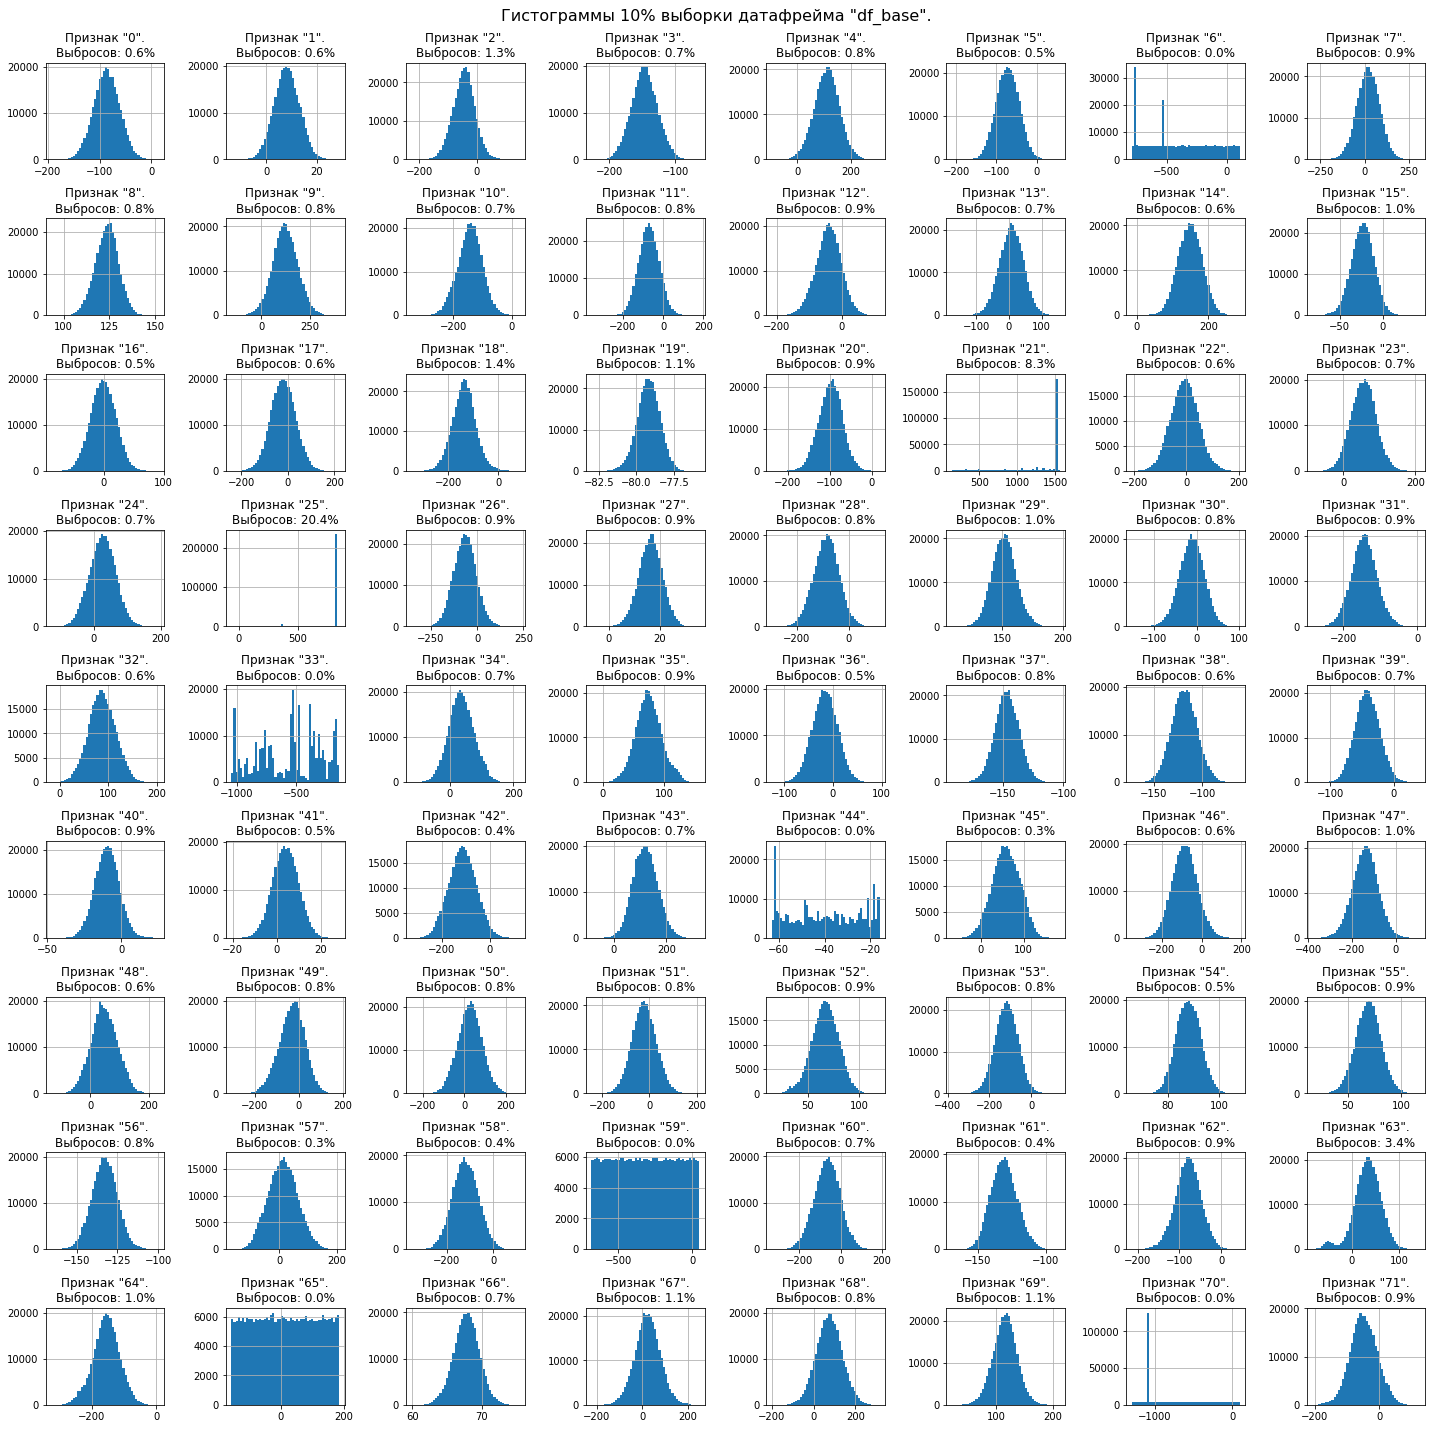

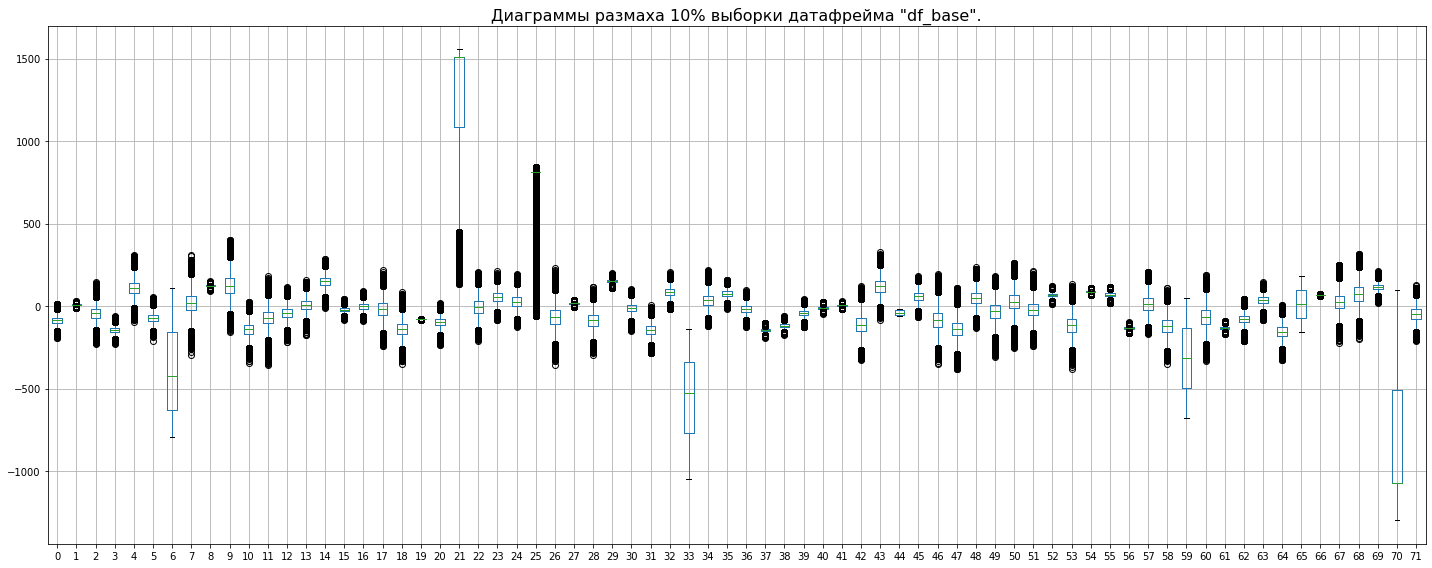

In [70]:
get_eda_plots(df=base_df, name='df_base', sample_frac=.1)

Большинство данных имеют вид _нормального распределения_ или очень схожего. В каждой колонке свой диапазон значений (широкий/узкий), встречаются как положительные та и отрицательные значения. Отдельное внимание стоит уделить столбцам №№ `6, 21, 25, 33, 44, 59, 65, 70`.

### Train

`Train` - набор из товаров новых поставок, для которых известны соответствующие товары из "старого" датасета base. ID этого товара содержится в отдельном датасете target.

Вывод общей информации.

In [71]:
%%time

display(train_df.head())
train_df.info()
print('Кол-во товаров-дубликатов:', train_df.duplicated().sum())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,target
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.936676,187.517487,-87.144928,-347.360596,38.307602,109.085564,30.413513,-88.082687,-52.695541,-27.692442,4.872923,198.348007,-30.075249,-3.803569,-135.810608,-161.841370,-78.512177,-94.428940,898.436951,-70.140518,78.420357,108.032776,813.770081,-74.790878,12.610422,-183.821838,149.715836,-27.042316,-133.212173,106.420746,-303.939240,48.730789,58.185707,24.250950,-151.224106,-104.282265,-34.492809,-12.587054,2.622891,-120.969917,149.991638,-31.948471,82.314430,-115.830467,-243.309387,6.622036,-132.197662,68.712563,-38.806824,62.937435,-132.654449,89.189026,87.039780,-121.279877,-6.986934,-206.513824,29.485588,-77.029587,-132.386169,-105.427818,70.107361,-155.802567,-101.965942,65.903793,34.457500,62.642094,134.763596,-415.750244,-25.958572,675816-base
1-query,-87.776367,6.806268,-32.054546,-177.260391,120.803329,-83.810593,-94.572746,-78.433090,124.915901,140.331070,-177.605804,-84.995514,42.810810,-57.256332,96.792534,-19.261467,0.739535,50.619213,-155.267029,-78.659431,-92.761490,353.157745,-34.744545,82.487106,-28.450592,813.770081,-137.529633,26.595627,-136.783447,153.357910,48.810093,-115.922150,87.464218,-222.286362,25.124149,91.887138,-30.636869,-136.593140,-140.500122,-43.449757,-7.226884,8.265747,-117.915466,149.150894,-18.751057,95.315384,-60.093273,-83.820580,37.449867,-23.298859,74.061081,-7.139753,75.862396,-112.045113,82.857727,54.067215,-134.005386,-26.142574,-214.632111,-457.848450,21.459618,-137.411362,-40.812233,4.669178,-151.697708,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092163,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118591,-180.401978,190.128433,-50.837620,26.943937,-30.447489,125.771164,211.607819,-86.346558,-35.666546,16.395317,-80.802849,137.908646,-23.532761,-47.256584,-16.650242,-194.505676,-78.372925,-69.324478,1507.231323,-52.500969,-34.165775,52.958652,813.770081,-18.021725,20.951107,-50.321781,158.760620,0.178065,-183.069672,99.053574,-1018.469543,-51.801121,97.766769,-10.865850,-144.423157,-133.819489,-78.902298,-17.200352,4.467452,-63.970737,154.639526,-30.211615,48.527401,-122.406639,-112.713623,53.461838,-31.117260,107.841507,16.482935,77.934479,-95.618729,91.460075,63.119511,-126.939247,8.066628,-195.677673,-163.119995,-72.830002,-139.223068,-52.031662,78.039764,-169.146194,82.144188,66.008217,18.400496,212.409729,121.931473,-1074.464844,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.011360,94.652840,-109.255409,-775.150146,79.186523,124.003098,242.650650,-146.517075,-159.469849,-13.844755,-6.113928,118.939255,-44.585907,9.559358,14.435648,-156.906830,-78.789322,-78.737091,1507.231323,19.957405,34.834290,-8.820732,813.770081,-125.606796,17.584084,-58.452904,141.281799,-54.959309,-136.988541,63.880493,-1018.469543,89.228928,65.919960,-24.078644,-152.334106,-91.199379,-28.225389,-4.767386,0.158236,-129.128662,122.958366,-30.800995,123.623398,-37.540867,-72.139801,71.240990,-168.115585,118.236450,-18.065195,37.255718,-137.691040,87.500771,62.437290,-131.260635,35.692661,-86.038834,-379.339081,-153.465775,-131.198288,-61.567047,44.515266,-145.416748,93.990982,64.131348,106.061920,83.178757,118.277725,-1074.464844,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.052536,57.127068,-16.239529,-321.317963,45.984676,125.941284,103.392670,-107.153023,-8.800034,-50.977798,29.457338,143.389313,5.614824,-45.274761,9.643625,-77.554626,-79.066612,-77.926460,1507.231323,16.612400,116.284286,33.754898,813.770081,-105.765335,6.523008,-19.812988,157.693924,-20.604088,-146.591278,78.849571,-780.449158,87.560768,73.036659,16.891029,-144.657898,-116.122147,-19.353254,-7.709266,-5.394988,-140.252121,193.184967,-53.

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float32
 1   1       100000 non-null  float32
 2   2       100000 non-null  float32
 3   3       100000 non-null  float32
 4   4       100000 non-null  float32
 5   5       100000 non-null  float32
 6   6       100000 non-null  float32
 7   7       100000 non-null  float32
 8   8       100000 non-null  float32
 9   9       100000 non-null  float32
 10  10      100000 non-null  float32
 11  11      100000 non-null  float32
 12  12      100000 non-null  float32
 13  13      100000 non-null  float32
 14  14      100000 non-null  float32
 15  15      100000 non-null  float32
 16  16      100000 non-null  float32
 17  17      100000 non-null  float32
 18  18      100000 non-null  float32
 19  19      100000 non-null  float32
 20  20      100000 non-null  float32
 21  21  

Удалим целевой признак.

In [72]:
train_targets = train_df['target']
train_df.drop('target', axis=1, inplace=True)

Построим графики распределения признаков.

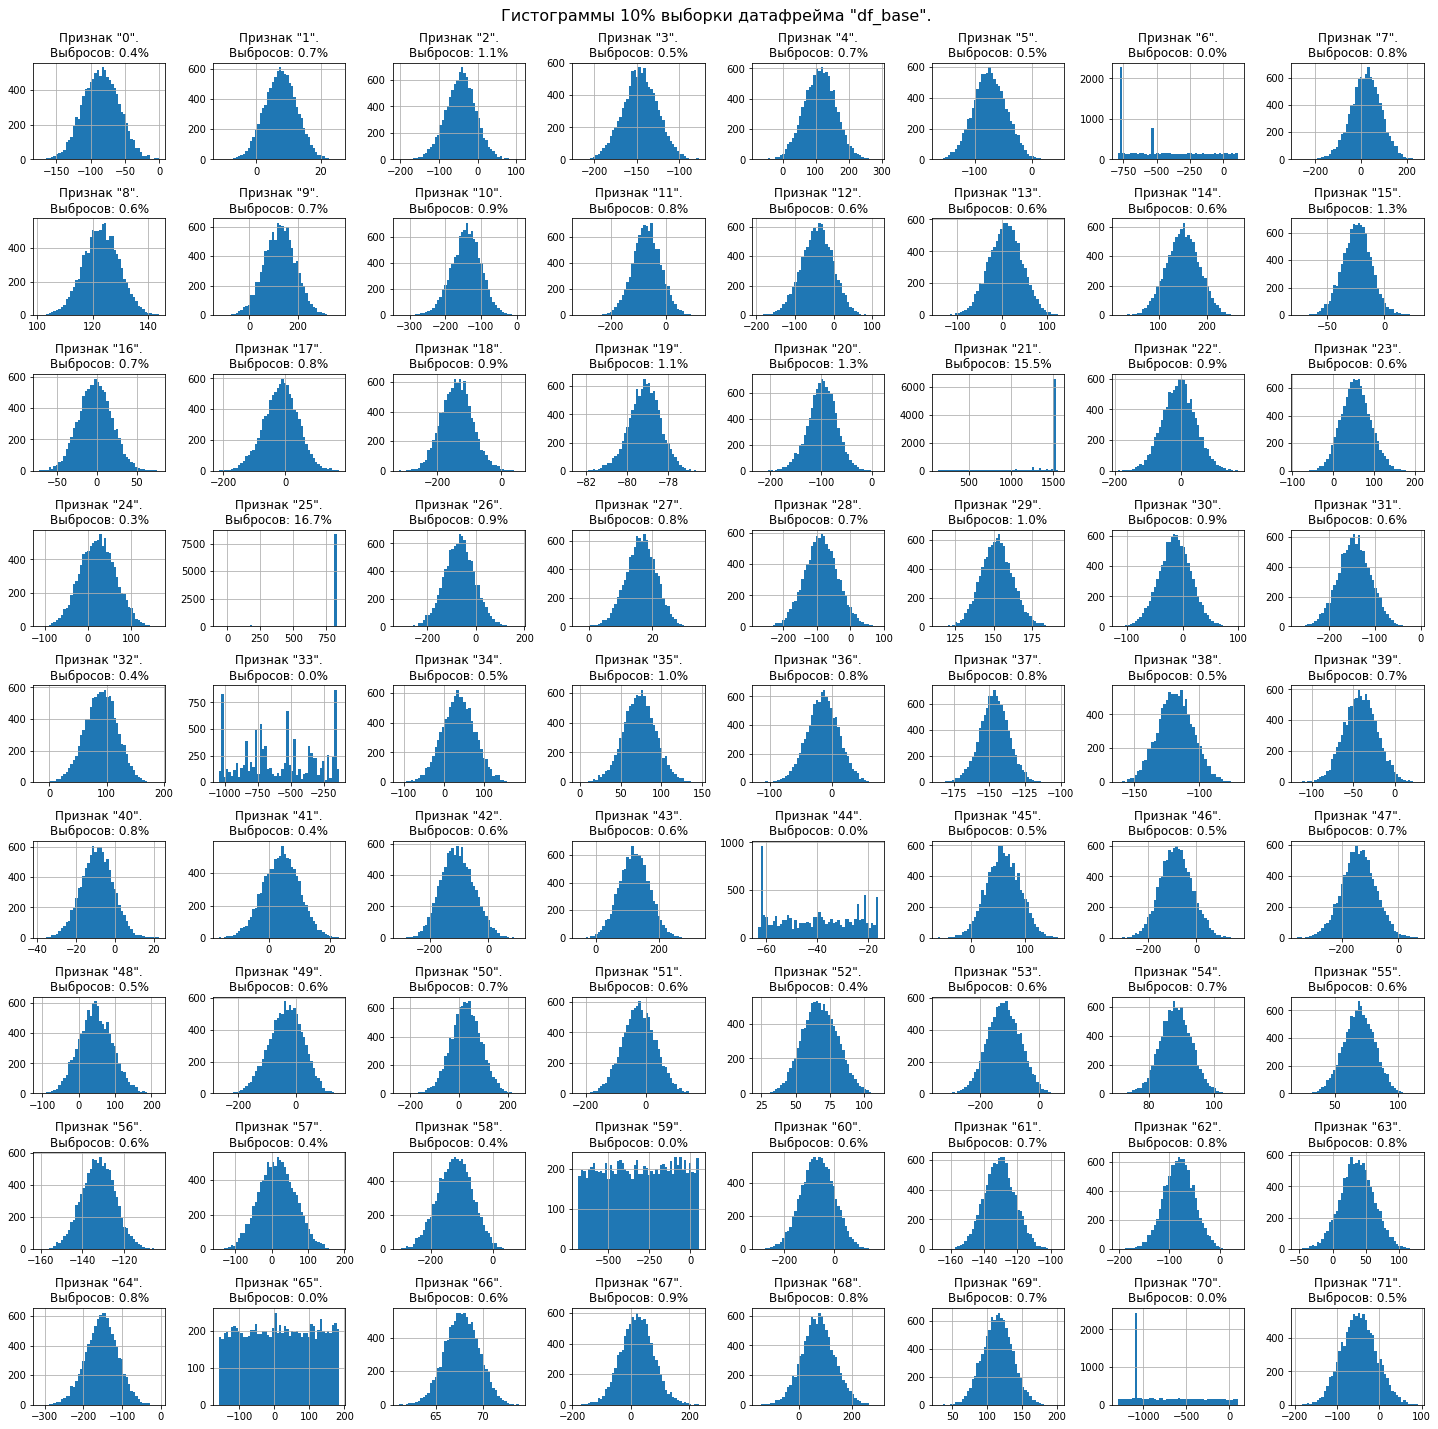

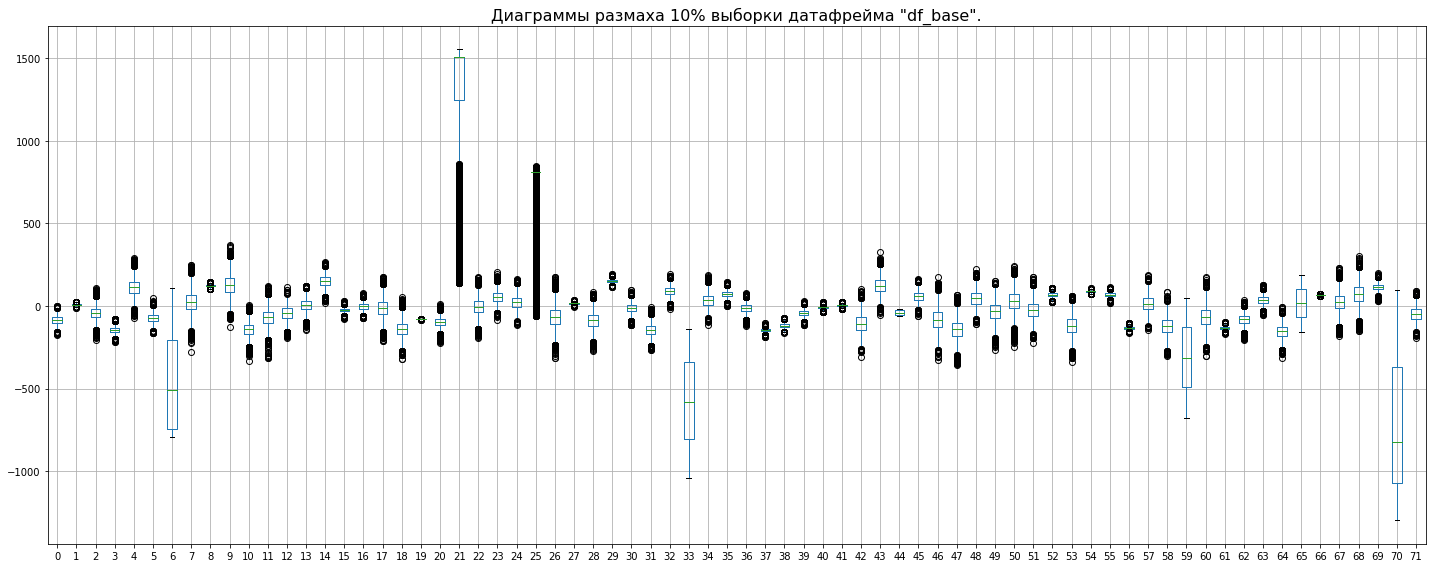

In [73]:
get_eda_plots(df=train_df, name='df_base', sample_frac=.1)

Тренировочные данные имеют аналогичный вид как в base.csv. Большинство данных имеют распределение близкое к нормальному. Также имеются аномалии в столбцах №№ `6, 21, 25, 33, 44, 59, 65, 70`.

### Valid

`Valid` - набор из товаров новых поставок, для которых НЕ известны соответствующие товары и их необходимо найти.

Вывод общей информации.

In [74]:
%%time

display(valid_df.head())
valid_df.info()
print('Кол-во товаров-дубликатов:', valid_df.duplicated().sum())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.926788,110.745941,-81.279594,-461.003174,139.815720,112.880981,75.215752,-131.892807,-140.968567,-57.987164,-22.868887,150.895523,7.965574,17.622066,-34.868217,-216.138550,-80.908730,-52.579521,263.363129,56.266876,66.924713,21.609911,813.770081,-32.782940,20.794031,-79.779076,156.307083,-42.831329,-71.723335,83.283661,-304.174377,1.609402,55.834587,-29.474255,-139.162766,-126.038353,-62.643829,-5.012346,11.984921,-43.084946,190.123993,-24.996635,76.153900,-245.261566,-143.656479,-4.259628,-46.664196,-27.085403,-34.346962,75.530106,-47.171707,92.697319,60.475632,-127.486870,-39.484753,-124.384575,-307.949768,45.506813,-144.190948,-75.513023,52.830902,-143.439453,59.051933,69.282242,61.927513,111.592529,115.140656,-1099.130493,-117.079361
100001-query,-53.758705,12.790300,-43.268543,-134.417618,114.449913,-90.520126,-759.626038,63.995087,127.117905,53.128998,-153.717255,-63.951328,-52.369495,-33.390945,148.619507,-22.483829,15.164185,-56.202000,-153.614380,-79.831825,-101.055481,1203.537109,81.597130,101.018654,56.783424,92.209625,-126.860336,10.382887,-38.523361,165.383911,-77.840485,-169.538681,103.483238,-915.735718,16.109938,14.669937,-38.707085,-149.538376,-138.792923,-36.076176,-2.781422,2.283144,-142.477890,189.953949,-18.408230,90.517052,-95.530998,-259.636047,52.437836,-30.004599,14.502060,-1.071201,66.842667,-161.279892,94.794174,50.419983,-125.075256,-25.169033,-176.176880,-655.836914,-99.238373,-141.535217,-79.441833,29.185436,-168.605896,-82.872444,70.765602,-65.975952,97.077164,123.391640,-744.442322,-25.009319
100002-query,-64.175095,-3.980927,-7.679249,-170.160934,96.446159,-62.377739,-759.626038,87.477554,131.270111,168.920319,-220.309540,-31.378445,-8.788761,2.285323,133.266113,-41.309078,14.305538,-18.231812,-205.533707,-78.160309,-96.607674,1507.231323,-5.964200,34.937443,-56.086887,813.770081,-13.200474,18.966661,-35.110191,151.368500,-17.490252,-145.884293,15.533379,-655.395508,39.412827,62.554955,9.924992,-143.934616,-123.107796,-37.032475,-13.501337,12.913328,-116.038017,176.276154,-45.909943,103.491364,-90.656990,-162.615707,117.128235,13.079479,69.826889,-6.874451,63.707214,-123.851067,91.610817,59.760067,-129.566177,-12.822194,-154.197647,-407.199066,5.522629,-126.812973,-134.795410,37.368729,-159.662308,-119.232727,67.710442,86.002060,137.636414,141.081635,-294.052277,-70.969604
100003-query,-99.286858,16.123936,9.837166,-148.060440,83.697083,-133.729721,58.576405,-19.046659,115.042404,75.206734,-114.271957,-71.406456,-65.349319,24.377069,50.467300,-14.721335,15.069309,-46.682995,-176.604370,-78.690697,-139.227448,325.547119,3.632292,74.929504,-4.802103,813.770081,-52.982597,15.644382,-54.087467,151.309143,21.088570,-134.507889,65.118958,-529.295044,131.565521,67.642700,-22.884491,-145.906525,-86.917328,-11.863579,-22.188885,0.463720,-212.533752,170.522583,-48.092533,99.712555,-194.692413,-141.523178,60.217049,73.386383,118.567856,58.900810,55.569031,-181.091660,83.340485,66.083237,-114.048866,-57.156872,-56.335075,-318.680054,-15.984783,-128.101334,-77.236107,44.100494,-132.530121,-106.318985,70.883957,23.577892,133.183960,143.252945,-799.363647,-89.392670
100004-query,-79.532921,-0.364173,-16.027431,-170.884949,165.453918,-28.291668,33.931934,34.411217,128.903976,102.086914,-76.214172,-26.393860,34.423641,50.938889,157.683182,-23.786497,-33.175415,-0.592607,-193.318542,-79.651031,-91.889786,1358.481079,44.027733,121.527206,46.182999,433.623108,-82.233200,21.068508,-32.940117,149.268951,0.404718,-97.674530,81.719994,-825.644775,9.397169,49.359341,17.725466,-160.168152,-129.367950,-55.532898,-2.597821,-0.226103,-41.369141,92.090195,-58.626858,73.655441,-10.257370,-175.656784,

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float32
 1   1       100000 non-null  float32
 2   2       100000 non-null  float32
 3   3       100000 non-null  float32
 4   4       100000 non-null  float32
 5   5       100000 non-null  float32
 6   6       100000 non-null  float32
 7   7       100000 non-null  float32
 8   8       100000 non-null  float32
 9   9       100000 non-null  float32
 10  10      100000 non-null  float32
 11  11      100000 non-null  float32
 12  12      100000 non-null  float32
 13  13      100000 non-null  float32
 14  14      100000 non-null  float32
 15  15      100000 non-null  float32
 16  16      100000 non-null  float32
 17  17      100000 non-null  float32
 18  18      100000 non-null  float32
 19  19      100000 non-null  float32
 20  20      100000 non-null  float32
 21

Посмортим на графики распределения признаков.

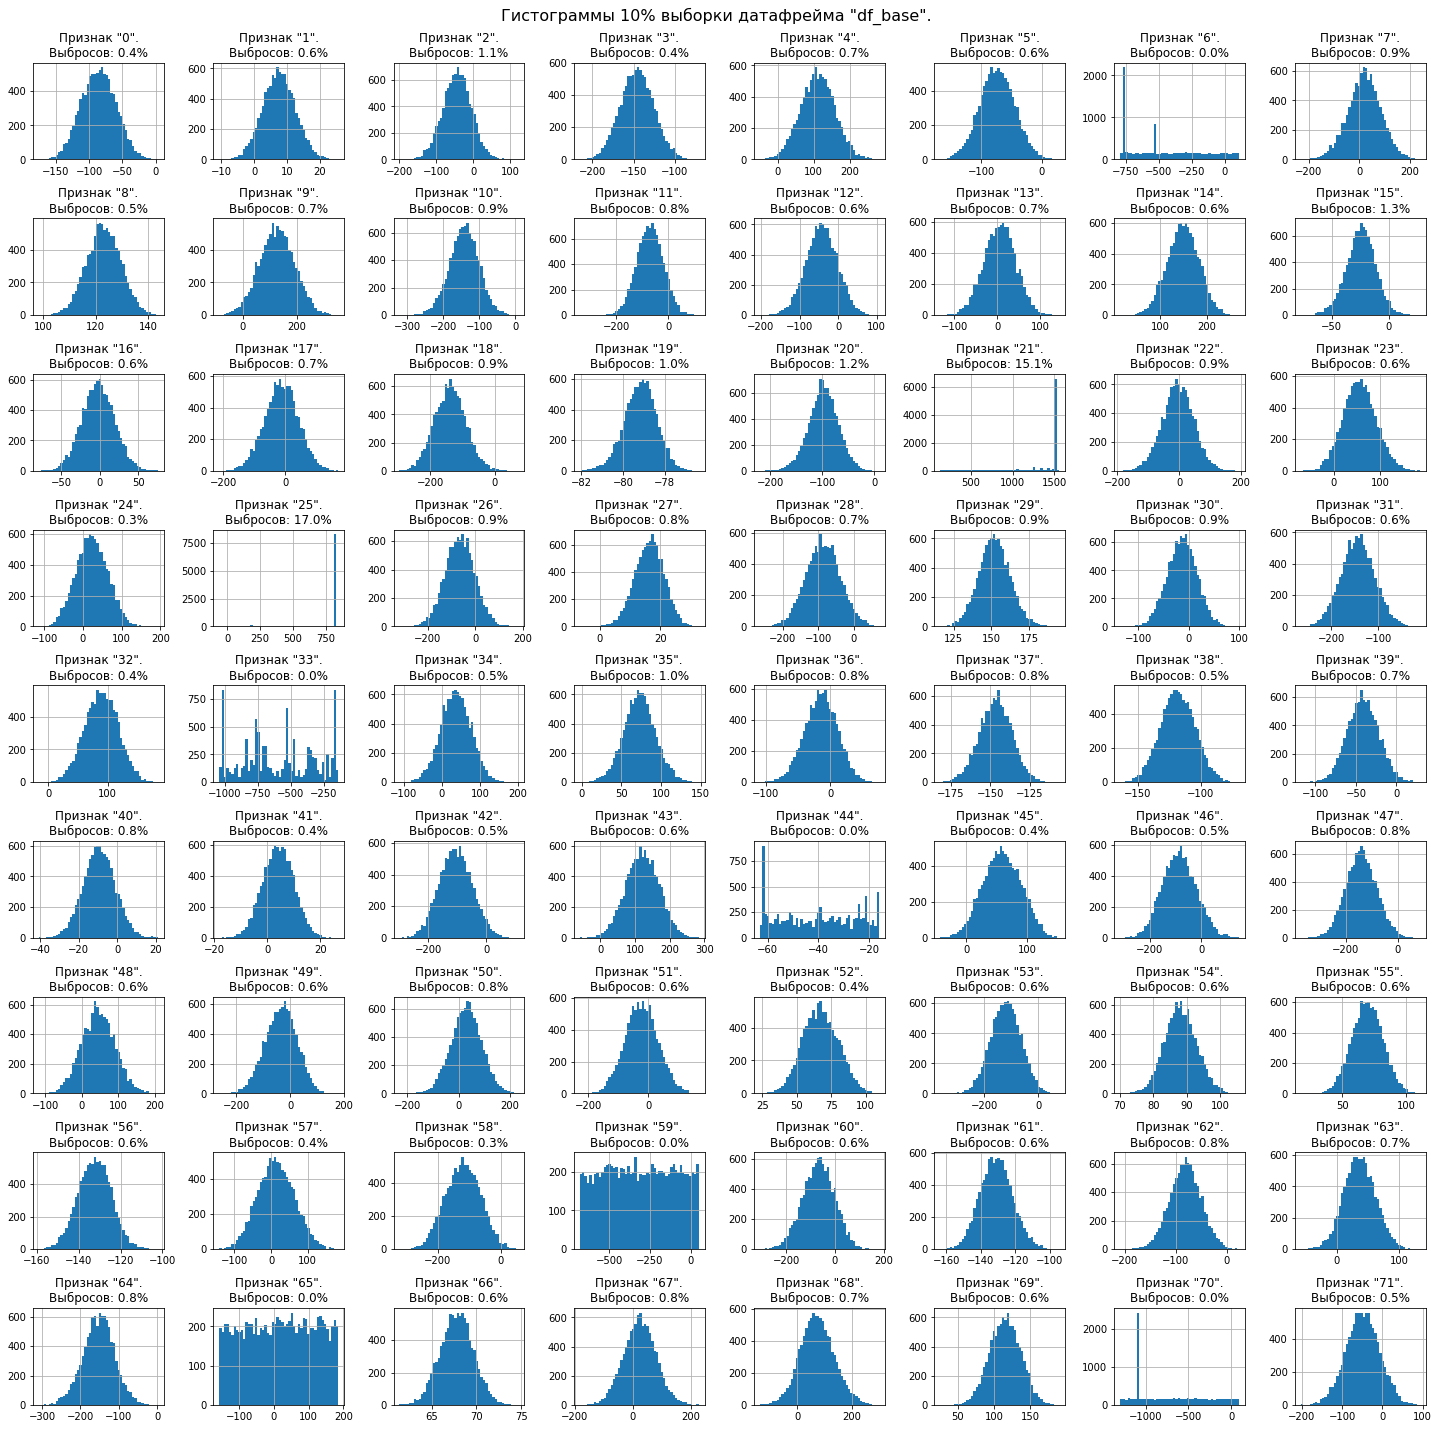

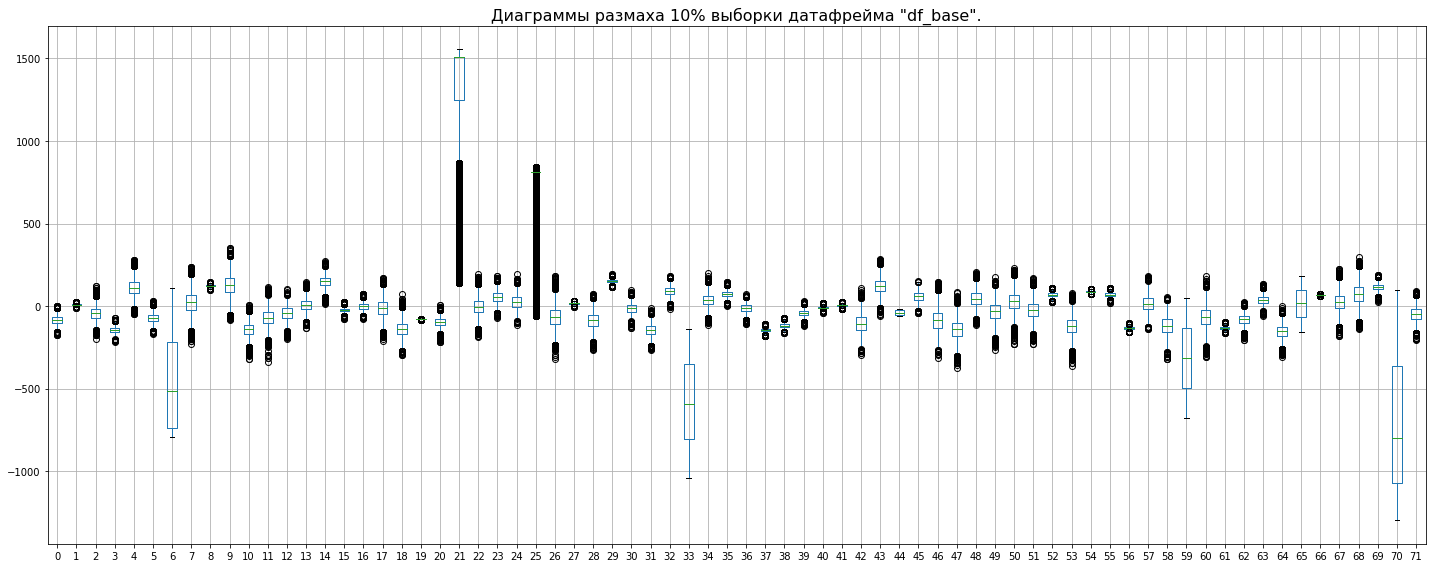

In [75]:
get_eda_plots(df=valid_df, name='df_base', sample_frac=.1)

Тренировочные данные имеют аналогичный вид как в base и train. Большинство данных имеют распределение близкое к нормальному. Также имеются аномалии в столбцах №№ `6, 21, 25, 33, 44, 59, 65, 70`.

### Valid_answer

`Valid_answer` - верные соответствующие товары для выборки Valid. Необходимо для тестирования обученной модели.

Вывод общей информации.

In [76]:
display(valid_targets.head())
valid_targets.info()
print('Кол-во товаров-дубликатов:', valid_targets.duplicated().sum())

,expected
id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   expected  100000 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB
Кол-во товаров-дубликатов: 8498


### Корреляция признаков

Проверим корреляцию между признаками методом phik.

In [77]:
phik_over = train_df.phik_matrix()

interval columns not set, guessing: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71']


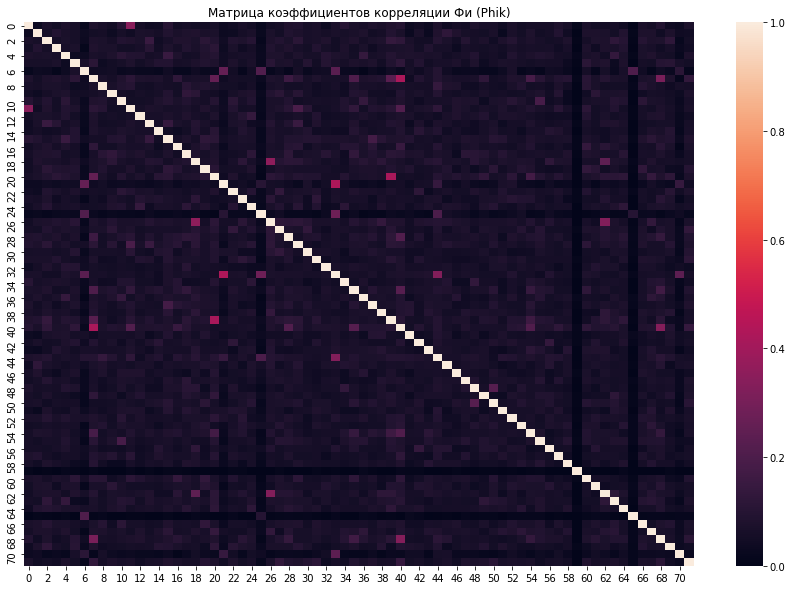

Wall time: 1min 25s


In [78]:
%%time

f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(train_df.phik_matrix(interval_cols=train_df.columns))
plt.title('Матрица коэффициентов корреляции Фи (Phik)')
plt.show()


Тип данных - соответствует. Все значения - это числа с плавающий запятов типа `float64`, а id товаров - данные типа `object` или `string`.

Пропуски - отсутствуют.

Выбросы / аномалии - отсутствует. Существует разве что "дисбаланс" между значениями. А именно, некоторые значения встречаются особо часто в сравнении со всеми остальными. К примеру: для признака №25 особо популярен значение 813.770071. Оно встречается у ~80% товаров.

Дубликаты - отсутствуют, за исключением `Valid_answer`. Это может говорить, что одному и тому же "старому" товару, может соответствовать несколько "новых".

Явная зависимость между признаками - отсутствует. Всех их можно считать уникальными характеристиками товара.

Значения признаков сильно отличаются друг от друга. Они могут быть как положительными, так и отрицательными. Могут занимать широкий или узкий числовой диапазон. Для того чтобы каждый признак изначально имел одинаковую значимость необходимо произвести **Масштабирование**.

### Масштабирование признаков

In [79]:
scaler = StandardScaler()
scaler.fit(base_df)
base_transform  = scaler.transform(base_df)
train_transform = scaler.transform(train_df)
valid_transform = scaler.transform(valid_df)

Данные готовы для обработки.

##  Поиск ближайших соседей

Принцип работы [Faiss](https://faiss.ai/index.html):
1. Отображение всех объектов (векторов) в едином пространстве
2. Деление полученного пространства на отдельные части (кластеры) при помощи спец. алгоритма библиотеки
3. Для каждого кластера происходит поиск его центра (центроида)
4. Таким образом, для нового вектора можно быстрой найти ближайших соседей, вычислив расстояние именно до центроидов (не перемножая новый вектор со всеми остальными векторами).
5. После выявления ближайшего кластера, новый вектор перемножается векторами только из этого кластера.

На этом этапе данные будут преобразованы из датафрейма в двумерный массив и в результате этого потеряют свои уникальные **id**. Заблаговременно необходимо создать словарь для сопоставления **порядкового номера** вектора (`161948`) и **id** товара (`'161948-base'`).

In [80]:
base_index = {k: v for k, v in enumerate(base_df.index.to_list())}

print('Пример содержания словаря:\n', list(base_index.items())[0:3])

Пример содержания словаря:
 [(0, '0-base'), (1, '1-base'), (2, '2-base')]


`FlatL2` - мера близости вектором L2-норма (евклидово расстояние). По этой причине большое значение имеет "нормализованы ли признаки?", поскольку в этой ситуации признак бóльшей величины будет играть бóльшую роль в предсказании. Но это не отображает достоверность его значимость.

`quantizer` - квантизатор, который получает на вход вектора размерностью `dimensions` и рассчитывает расстояние между ними по евклидовой норме.

`idx_l2` - пространство векторов размерностью `dimensions`, разделяемое на фиксированное кол-во кластеров из `N_CLUSTERS` с помощью `quantizer`.

In [81]:
dimensions = base_transform.shape[1] # n-мерность векторов

quantizer = faiss.IndexFlatL2(dimensions)
idx_l2 = faiss.IndexIVFFlat(quantizer, dimensions, N_CLUSTERS)

Функция `np.ascontiguousarray()` располагает последовательно весь массив данных в оперативной памяти.

In [82]:
# обучение делителя пространства на первых 50 тысячах объектов из df_base
idx_l2.train(np.ascontiguousarray(base_transform[:50000, :]).astype('float32'))

# деление всех векторов по правилам, сформированным на предыдущем шаге 
idx_l2.add(np.ascontiguousarray(base_transform).astype('float32'))

Далее следует **процесс поиска** соседей. Дословно строчка кода звучит так: для каждого вектора из `trans_train` найди по **N** ближайших векторов из `df_base` (которые уже размечены на отдельные кластеры). Результатом являются:
- `idx` - порядковые номера ближайших векторов, и
- `distance` - расстояние между векторами.


In [83]:
%%time
distance, train_idx = idx_l2.search(np.ascontiguousarray(train_transform).astype('float32'), K_NEIGHBORS)

print(f'Примеры train_idx :\n {train_idx[:3]} \n')
print(f'Примеры vectors :\n {distance[:3]} \n')
del distance

Примеры train_idx :
 [[ 598613  755584  336969 1934845   13374 1136231  480296  583287 2360257
   450667  988777 1653095 1818641  503716 1631947   89840  143978  986050
   629775 2346335  223859  352715  455829 1747988 1674977  443428 2295048
   728097 1113711 1746258]
 [  15185  902634  223456  464427 2524968  838522  124343 2162616 1325497
   295462 1946148  224544  898791  412497 2469267 2584784    2133 2175159
  1747103 1252594  413070  334268 2157980 1357222 1445783 1069399  838183
   690454 2339086 1125764]
 [ 173120 1784963 2863071 1143288  955831  137853 1368891 1162532  774247
  1984148 1479188 1238526 2351134  641280 1532675 1774212  948608   12304
  2395210 1905367 1341266 2642468 2475151  859626  182696 1392119 1359128
  2710601 1495133 1659033]] 

Примеры vectors :
 [[19.299541 19.4676   20.747223 23.19997  23.545162 23.618982 26.231094
  26.317614 26.367298 26.425816 26.577126 27.139732 27.454794 27.815866
  28.002178 28.12624  28.746384 28.74659  28.77865  28.836002 28.9

`targets` - список `id` товаров, подходящих по мнению экспертов. (одномерный массив)

`idx` - наборы из k ближайших соседей. Для получения `id` товара, нужно указать числовой индекс в словаре `base_index`. 

Функция для вычисления accuracy5n.

In [84]:
def accuracy_n(targets, predict, base_index=base_index):
    acc = 0
    for target, candidates in zip(targets.tolist(), predict.tolist()):
        acc += int(target in [base_index[number] for number in candidates])

    return (acc / len(predict) * 100)

Создано и наполнено векторное пространство из объектов датасета `base`. Выделено 200 кластеров, что ускоряет и уточняет процесс поиска. Для каждого объекта из `train` были найдены 50 ближайших векторов при помощи меры `FlatL2`. 

 Для 62.01% новых товара из датасета `train` найдено 100 кандидатов для сопоставления, среди которах есть целевой (т.е. выбранный экспертом).

Число кластеров и кол-во ближайших соседей подобраны экспериментальным путём. При этом первый параметр влияет на скорость поиска, а второй - на качество поиска.

Далее, среди найденных кандидатов необходимо выявить самый подходящий. Для этого их требуется отсортировать.

## Ранжирование данных

### Формирование тренировочной выборки

Первым делом необходимо составить новый датафрейм состоящий из двух половин:
1. Искомые векторы
2. Несколько кандидатов на сопоставление для каждого искомого вектора.

Последним столбцом для этого вектора станет `matching` содержащий правильный ответ: 1 - вектор подходит, 0 - вектор не подходим.

Чтобы провести дальнейшую работу необходимо экономно распоряжаться объёмом ОП, и некоторые неиспользуемые данные будут удалиться.

In [85]:
idx_df = pd.DataFrame(data=train_idx, index=train_df.index)
idx_df = pd.melt(idx_df.T)
idx_df.columns = ['id_query', 'candidate']
idx_df['id_candidate'] = [base_index[number] for number in idx_df['candidate'].values]
idx_df.drop('candidate', axis=1, inplace=True)
del train_idx



Полученные колонки с `id` товаров будут использованы для объединения при помощи метода `merge()`. В качестве данных будут использоваться уже отмасштабированные признаки.

In [32]:
base_transform_df  = pd.DataFrame(base_transform,  index=base_df.index)
train_transform_df = pd.DataFrame(train_transform, index=train_df.index)
del base_transform, train_transform

# объединение base и train по заготовленным id
train_base_df = idx_df.merge(train_transform_df, left_on='id_query', right_on='id', how='left')
train_base_df = train_base_df.merge(base_transform_df, left_on='id_candidate', right_on='id', how='left', suffixes=('', '_base'))
train_base_df = train_base_df.merge(train_targets, left_on='id_query', right_on='id', how='left')
del idx_df, train_transform_df

display(train_base_df)

,id_query,id_candidate,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,...,23_base,24_base,25_base,26_base,27_base,28_base,29_base,30_base,31_base,32_base,33_base,34_base,35_base,36_base,37_base,38_base,39_base,40_base,41_base,42_base,43_base,44_base,45_base,46_base,47_base,48_base,49_base,50_base,51_base,52_base,53_base,54_base,55_base,56_base,57_base,58_base,59_base,60_base,61_base,62_base,63_base,64_base,65_base,66_base,67_base,68_base,69_base,70_base,71_base,target
0,0-query,675816-base,1.299518,1.996888,0.063774,-1.879670,1.644099,-0.537626,0.165148,0.279598,-2.296794,-1.459626,1.320710,0.335633,0.348338,-0.074182,1.467578,-0.528330,-0.137619,-2.199224,-0.526967,0.893985,0.135834,-0.897816,-1.218252,0.632892,2.088698,0.421591,-0.138746,-0.795630,-2.008673,-0.200075,-0.533139,0.317073,0.689298,0.959996,0.313108,-0.793275,1.575643,-0.460326,1.08261,0.384758,-0.379061,-0.244658,-0.144466,0.623425,0.533131,0.72798,-0.489634,-1.815781,...,0.474287,2.433729,0.421591,-0.433625,-0.509268,-2.143207,-0.150344,-0.575221,-0.359227,0.721840,1.526618,-0.204713,-1.441978,1.256688,-0.341044,0.377313,0.542706,-0.894267,-0.180352,-0.293626,0.160861,0.712484,0.937155,-0.388536,-1.245315,-0.590014,-1.959322,-0.622100,0.003149,0.588065,-0.407769,-0.769536,0.605292,0.933951,-0.228254,-1.799301,1.521596,-0.045023,-0.591869,-0.927103,1.627806,0.072924,0.427460,-0.496641,0.394758,-0.568302,0.066837,0.995267,0.708902,675816-base
1,0-query,877519-base,1.299518,1.996888,0.063774,-1.879670,1.644099,-0.537626,0.165148,0.279598,-2.296794,-1.459626,1.320710,0.335633,0.348338,-0.074182,1.467578,-0.528330,-0.137619,-2.199224,-0.526967,0.893985,0.135834,-0.897816,-1.218252,0.632892,2.088698,0.421591,-0.138746,-0.795630,-2.008673,-0.200075,-0.533139,0.317073,0.689298,0.959996,0.313108,-0.793275,1.575643,-0.460326,1.08261,0.384758,-0.379061,-0.244658,-0.144466,0.623425,0.533131,0.72798,-0.489634,-1.815781,...,0.604063,1.044933,0.421591,0.105384,-0.137481,-0.777557,-1.002830,-0.782513,1.096548,0.391772,0.959996,0.273355,-1.144415,1.767315,-0.452613,0.732114,0.489616,-0.508627,0.239832,0.052073,0.142065,0.533131,1.153803,-0.834560,-1.375728,-0.755042,-1.742866,0.027035,0.575624,-0.673431,-0.640479,0.287307,1.584155,1.517666,-0.224322,-1.684974,-0.208441,0.690645,-0.042306,-0.676032,1.615281,-0.247046,-0.404396,-1.148503,0.412697,-0.375744,0.728224,0.544932,0.270560,675816-base
2,0-query,361564-base,1.299518,1.996888,0.063774,-1.879670,1.644099,-0.537626,0.165148,0.279598,-2.296794,-1.459626,1.320710,0.335633,0.348338,-0.074182,1.467578,-0.528330,-0.137619,-2.199224,-0.526967,0.893985,0.135834,-0.897816,-1.218252,0.632892,2.088698,0.421591,-0.138746,-0.795630,-2.008673,-0.200075,-0.533139,0.317073,0.689298,0.959996,0.313108,-0.793275,1.575643,-0.460326,1.08261,0.384758,-0.379061,-0.244658,-0.144466,0.623425,0.533131,0.72798,-0.489634,-1.815781,...,0.464460,1.389150,0.421591,-0.059258,-0.177924,-1.517607,-0.437985,-0.612435,1.002465,0.301101,0.535625,0.499960,-0.667007,1.744726,-0.262867,1.051505,0.367421,-0.548770,0.078778,0.430015,0.845793,0.712484,0.911999,-0.254066,-0.725009,-0.836182,-1.926362,0.298095,0.250594,-0.195698,-0.844313,0.156500,1.230217,1.529387,0.119707,-1.997447,0.637073,0.414040,0.216622,-0.332150,1.723392,-0.369458,0.988497,-1.100242,0.280916,-0.492041,0.532096,0.543575,0.090279,675816-base
3,0-query,2725256-base,1.299518,1.996888,0.063774,-1.879670,1.644099,-0.537626,0.165148,0.279598,-2.296794,-1.459626,1.320710,0.335633,0.348338,-0.074182,1.467578,-0.528330,-0.137619,-2.199224,-0.526967,0.893985,0.135834,-0.897816,-1.218252,0.632892,2.088698,0.421591,-0.138746,-0.795630,-2.008673,-0.200075,-0.533139,0.317073,0.689298,0.959996,0.313108,-0.793275,1.575643,-0.460326,1.08261,0.384758,-0.379061,-0.244658,-0.144466,0.623425,0.533131,0.72798,-0.489634,-1.815781,...,0.088106,0.818258,0.421591,-0.800142,0.382405,-1.701091,0.039260,-0.466624,1.284633,0.424482,1.12

Преобразуем целевой признак для бинарной классификации.

In [33]:

train_base_df['matching'] = (train_base_df['id_candidate'] == train_base_df['target']).astype('int')
display(train_base_df[['id_query', 'id_candidate', 'target', 'matching']])
train_base_df.drop('target', axis=1, inplace=True)

,id_query,id_candidate,target,matching
0,0-query,675816-base,675816-base,1
1,0-query,877519-base,675816-base,0
2,0-query,361564-base,675816-base,0
3,0-query,2725256-base,675816-base,0
4,0-query,13406-base,675816-base,0
...,...,...,...,...
2999995,99999-query,2426595-base,2769109-base,0
2999996,99999-query,534314-base,2769109-base,0
2999997,99999-query,907013-base,2769109-base,0
2999998,99999-query,51621-base,2769109-base,0


Выделим целевой признак.

In [34]:
y_train = train_base_df['matching']
X_train = train_base_df.drop(['id_query', 'id_candidate', 'matching'] , axis=1)
del train_base_df

display(y_train.to_frame())
display(X_train)

,matching
0,1
1,0
2,0
3,0
4,0
...,...
2999995,0
2999996,0
2999997,0
2999998,0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,22_base,23_base,24_base,25_base,26_base,27_base,28_base,29_base,30_base,31_base,32_base,33_base,34_base,35_base,36_base,37_base,38_base,39_base,40_base,41_base,42_base,43_base,44_base,45_base,46_base,47_base,48_base,49_base,50_base,51_base,52_base,53_base,54_base,55_base,56_base,57_base,58_base,59_base,60_base,61_base,62_base,63_base,64_base,65_base,66_base,67_base,68_base,69_base,70_base,71_base
0,1.299518,1.996888,0.063774,-1.879670,1.644099,-0.537626,0.165148,0.279598,-2.296794,-1.459626,1.320710,0.335633,0.348338,-0.074182,1.467578,-0.528330,-0.137619,-2.199224,-0.526967,0.893985,0.135834,-0.897816,-1.218252,0.632892,2.088698,0.421591,-0.138746,-0.795630,-2.008673,-0.200075,-0.533139,0.317073,0.689298,0.959996,0.313108,-0.793275,1.575643,-0.460326,1.08261,0.384758,-0.379061,-0.244658,-0.144466,0.623425,0.533131,0.72798,-0.489634,-1.815781,-0.913808,-1.712483,...,-1.263066,0.474287,2.433729,0.421591,-0.433625,-0.509268,-2.143207,-0.150344,-0.575221,-0.359227,0.721840,1.526618,-0.204713,-1.441978,1.256688,-0.341044,0.377313,0.542706,-0.894267,-0.180352,-0.293626,0.160861,0.712484,0.937155,-0.388536,-1.245315,-0.590014,-1.959322,-0.622100,0.003149,0.588065,-0.407769,-0.769536,0.605292,0.933951,-0.228254,-1.799301,1.521596,-0.045023,-0.591869,-0.927103,1.627806,0.072924,0.427460,-0.496641,0.394758,-0.568302,0.066837,0.995267,0.708902
1,1.299518,1.996888,0.063774,-1.879670,1.644099,-0.537626,0.165148,0.279598,-2.296794,-1.459626,1.320710,0.335633,0.348338,-0.074182,1.467578,-0.528330,-0.137619,-2.199224,-0.526967,0.893985,0.135834,-0.897816,-1.218252,0.632892,2.088698,0.421591,-0.138746,-0.795630,-2.008673,-0.200075,-0.533139,0.317073,0.689298,0.959996,0.313108,-0.793275,1.575643,-0.460326,1.08261,0.384758,-0.379061,-0.244658,-0.144466,0.623425,0.533131,0.72798,-0.489634,-1.815781,-0.913808,-1.712483,...,-1.093784,0.604063,1.044933,0.421591,0.105384,-0.137481,-0.777557,-1.002830,-0.782513,1.096548,0.391772,0.959996,0.273355,-1.144415,1.767315,-0.452613,0.732114,0.489616,-0.508627,0.239832,0.052073,0.142065,0.533131,1.153803,-0.834560,-1.375728,-0.755042,-1.742866,0.027035,0.575624,-0.673431,-0.640479,0.287307,1.584155,1.517666,-0.224322,-1.684974,-0.208441,0.690645,-0.042306,-0.676032,1.615281,-0.247046,-0.404396,-1.148503,0.412697,-0.375744,0.728224,0.544932,0.270560
2,1.299518,1.996888,0.063774,-1.879670,1.644099,-0.537626,0.165148,0.279598,-2.296794,-1.459626,1.320710,0.335633,0.348338,-0.074182,1.467578,-0.528330,-0.137619,-2.199224,-0.526967,0.893985,0.135834,-0.897816,-1.218252,0.632892,2.088698,0.421591,-0.138746,-0.795630,-2.008673,-0.200075,-0.533139,0.317073,0.689298,0.959996,0.313108,-0.793275,1.575643,-0.460326,1.08261,0.384758,-0.379061,-0.244658,-0.144466,0.623425,0.533131,0.72798,-0.489634,-1.815781,-0.913808,-1.712483,...,-0.910233,0.464460,1.389150,0.421591,-0.059258,-0.177924,-1.517607,-0.437985,-0.612435,1.002465,0.301101,0.535625,0.499960,-0.667007,1.744726,-0.262867,1.051505,0.367421,-0.548770,0.078778,0.430015,0.845793,0.712484,0.911999,-0.254066,-0.725009,-0.836182,-1.926362,0.298095,0.250594,-0.195698,-0.844313,0.156500,1.230217,1.529387,0.119707,-1.997447,0.637073,0.414040,0.216622,-0.332150,1.723392,-0.369458,0.988497,-1.100242,0.280916,-0.492041,0.532096,0.543575,0.090279
3,1.299518,1.996888,0.063774,-1.879670,1.644099,-0.537626,0.165148,0.279598,-2.296794,-1.459626,1.320710,0.335633,0.348338,-0.074182,1.467578,-0.528330,-0.137619,-2.199224,-0.526967,0.893985,0.135834,-0.897816,-1.218252,0.632892,2.088698,0.421591,-0.138746,-0.795630,-2.008673,-0.200075,-0.533139,0.317073,0.689298,0.959996,0.313108,-0.793275,1.575643,-0.460326,1.08261,0.384758,-0.379061,-0.244658,-0.144466,0.623425,0.533131,0.72798,-0.489634,-1.815781,-0.913808,-1.712483,...,-1.302782,0.088106,0.818258,0.421591,-0.800142,0.382405,-1.701091,0.039260,-0.466624,1.284633,0.424482,1.122449,0.71022

В результате получилась выборка для обучения:

массив из 2 000 000 записей = 100 000 новых товаров (query) * 20 ближайших кандидатов для каждого.

массив из 144 признаков = 72 признака "старых" товаров из `base` + 72 признака "новых" товаров из `train`.

бинарный целевой признак. 

### Формирование валидационной выборки

Повторим процедуры для валидационной выборки.

In [35]:
%%time

distance, valid_idx = idx_l2.search(np.ascontiguousarray(valid_transform), K_NEIGHBORS)
del distance

print(f'Примеры idx: \n {valid_idx[:3]} \n')
print('accuracy@{}: {:.2f}% \n'.format(K_NEIGHBORS, accuracy_n(valid_targets['expected'], valid_idx)))

Примеры idx: 
 [[2192372 2177660  342838  574649 1954150 2363873 1225777 1405698 2910875
  1719453 2512787 2504096 1243148 2571634  536120  995930  462353  814942
  1508869 2536973 2239161  340288  106841  999102  277780 2875559 2886161
  1837653 1952068 1869523]
 [  11829 2055627 1181240 1902639 1274898 2569205 1937168 2916203  804468
  1588070 2823570 2402606  997709 1501018   63166  421028 2137240 2570573
  2705300 2051707 2592310 1377814  367614 2735785 1972162 1236324 2172750
  1350091 1749172  119053]
 [ 431806 1555264 1139764 2405045 1827570  320337 1428654 2113531 1755547
  1920685  851206 2383962  870467  506913 1610744 2728874  655653  902657
    83318   46026  533517  394984 2511513  529303  539126 1886420 2329410
    16955 1292872 2351022]] 

accuracy@30: 60.54% 

Wall time: 42.3 s


Подготовим датафрейм с перечнем ID новых и старых объектов.

In [36]:
idx_df = pd.DataFrame(data=valid_idx, index=valid_df.index)
idx_df = pd.melt(idx_df.T)
idx_df.columns = ['id_query', 'candidate']
idx_df['id_candidate'] = [base_index[number] for number in idx_df['candidate'].values]
idx_df.drop('candidate', axis=1, inplace=True)
del valid_idx

display(idx_df)

,id_query,id_candidate
0,100000-query,3209652-base
1,100000-query,3181043-base
2,100000-query,368296-base
3,100000-query,645855-base
4,100000-query,2760762-base
...,...,...
2999995,199999-query,137573-base
2999996,199999-query,1432135-base
2999997,199999-query,1849089-base
2999998,199999-query,22275-base


Сформируем датафрейм из масштабированных данных.

In [37]:
%%time

valid_transform_df = pd.DataFrame(valid_transform, index=valid_df.index)
del valid_transform


Wall time: 0 ns


Объединим base и valid по списку ближайших соседей.

In [38]:
%%time
valid_base_df = idx_df.merge(valid_transform_df, left_on='id_query', right_on='id', how='left')
valid_base_df = valid_base_df.merge(base_transform_df, left_on='id_candidate', right_on='id', how='left', suffixes=('','_base'))
valid_base_df = valid_base_df.merge(valid_targets, left_on='id_query', right_on='id', how='left')
del idx_df, valid_transform_df, base_transform_df

display(valid_base_df)

,id_query,id_candidate,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,...,23_base,24_base,25_base,26_base,27_base,28_base,29_base,30_base,31_base,32_base,33_base,34_base,35_base,36_base,37_base,38_base,39_base,40_base,41_base,42_base,43_base,44_base,45_base,46_base,47_base,48_base,49_base,50_base,51_base,52_base,53_base,54_base,55_base,56_base,57_base,58_base,59_base,60_base,61_base,62_base,63_base,64_base,65_base,66_base,67_base,68_base,69_base,70_base,71_base,expected
0,100000-query,3209652-base,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,-0.253186,1.860318,-1.699665,-0.764269,0.269789,-1.38778,-0.429176,-0.832212,0.056796,2.380963,0.890877,-0.293647,-1.691501,-2.270031,1.622037,-2.485654,1.213946,0.298333,-0.130599,0.421591,0.543940,0.961781,0.135958,0.453171,-1.078517,2.086161,-0.141311,0.959094,-0.868026,-0.902899,-0.502330,0.751393,-0.572587,-1.081679,0.545730,1.359597,1.223365,1.482423,1.004608,0.536125,-2.537811,-0.089837,...,0.667430,-0.254617,0.421591,0.750456,0.983875,0.326141,0.502297,-0.965376,1.496369,-0.187717,1.277174,-1.195988,-0.400885,-0.671438,1.041164,-1.236503,-1.543153,0.725283,1.452080,1.286586,1.045977,1.004608,0.079816,-2.467238,-0.104059,-0.781992,-0.195419,-0.993647,0.006892,1.088652,0.918509,1.074081,-0.553307,0.364365,-1.451121,-0.647153,0.518863,1.655191,-1.929757,0.457505,0.948873,0.570802,1.213205,0.909869,0.897679,0.018913,0.430446,-0.713847,-1.182590,2676668-base
1,100000-query,3181043-base,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,-0.253186,1.860318,-1.699665,-0.764269,0.269789,-1.38778,-0.429176,-0.832212,0.056796,2.380963,0.890877,-0.293647,-1.691501,-2.270031,1.622037,-2.485654,1.213946,0.298333,-0.130599,0.421591,0.543940,0.961781,0.135958,0.453171,-1.078517,2.086161,-0.141311,0.959094,-0.868026,-0.902899,-0.502330,0.751393,-0.572587,-1.081679,0.545730,1.359597,1.223365,1.482423,1.004608,0.536125,-2.537811,-0.089837,...,0.270182,-0.382147,0.421591,0.815588,0.452389,0.192999,0.529316,-0.576054,1.311491,0.143591,0.185334,-0.507355,-0.688282,-0.361578,1.173270,-1.419797,-0.903053,0.753233,1.386468,1.724109,1.437901,1.004608,0.568009,-2.323148,0.376811,-0.820757,-0.391690,-1.172109,0.531079,0.726593,0.961491,0.825806,-0.277251,0.828892,-1.408781,-0.661294,0.178036,1.465034,-1.704227,0.190811,0.477240,-0.017377,0.170011,0.557127,0.766064,0.048265,0.406470,-0.713847,-1.284064,2676668-base
2,100000-query,368296-base,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,-0.253186,1.860318,-1.699665,-0.764269,0.269789,-1.38778,-0.429176,-0.832212,0.056796,2.380963,0.890877,-0.293647,-1.691501,-2.270031,1.622037,-2.485654,1.213946,0.298333,-0.130599,0.421591,0.543940,0.961781,0.135958,0.453171,-1.078517,2.086161,-0.141311,0.959094,-0.868026,-0.902899,-0.502330,0.751393,-0.572587,-1.081679,0.545730,1.359597,1.223365,1.482423,1.004608,0.536125,-2.537811,-0.089837,...,0.295417,-0.512554,0.421591,0.273008,1.082671,0.378518,0.848038,-0.325103,1.204312,-0.741427,-1.048883,-0.441693,-0.973180,-0.161742,0.794345,-1.071469,-1.087417,0.491749,1.395398,1.222792,1.255459,1.004608,0.593552,-2.518283,0.398540,-0.693608,-0.175038,-0.412272,0.097890,0.727748,1.190678,0.971942,-0.242553,0.343901,-0.756350,-0.466592,-0.468413,1.588136,-1.642732,-0.228085,0.011799,0.883902,1.235784,0.495694,0.563696,0.170485,-0.324675,-1.051440,-1.097352,2676668-base
3,100000-query,645855-base,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,-0.253186,1.860318,-1.699665,-0.764269,0.269789,-1.38778,-0.429176,-0.832212,0.056796,2.380963,0.890877,-0.293647,-1.691501,-2.270031,1.622037,-2.485654,1.213946,0.298333,-0.130599,0.421591,0.543940,0.961781,0.135958,0.453171,-1.078517,2.086161,-0.141311,0.959094,-0.868026,-0.902899,-0.502330,0.751393,-0.572587,-1.081679,0.545730,1.359597,1.223365,1.482423,1.004608,0.536125,-2.537811,-0.089837,...,0.268480,-0.084819,0.421591,0.707309,0.727723,0.701516,0.199011,-0.857694,1

Wall time: 31.1 s


Преобразуем целевой признак для бинарной классификации.

In [39]:

valid_base_df['matching'] = (valid_base_df['id_candidate'] == valid_base_df['expected']).astype('int')
display(valid_base_df[['id_query', 'id_candidate', 'expected', 'matching']])
valid_base_df.drop('expected', axis=1, inplace=True)

,id_query,id_candidate,expected,matching
0,100000-query,3209652-base,2676668-base,0
1,100000-query,3181043-base,2676668-base,0
2,100000-query,368296-base,2676668-base,0
3,100000-query,645855-base,2676668-base,0
4,100000-query,2760762-base,2676668-base,0
...,...,...,...,...
2999995,199999-query,137573-base,336472-base,0
2999996,199999-query,1432135-base,336472-base,0
2999997,199999-query,1849089-base,336472-base,0
2999998,199999-query,22275-base,336472-base,0


Выделим целевой признак.

In [40]:

y_valid = valid_base_df['matching']
X_valid = valid_base_df.drop(['id_query', 'id_candidate', 'matching'] , axis=1)


display(y_valid.to_frame())
display(X_valid)

,matching
0,0
1,0
2,0
3,0
4,0
...,...
2999995,0
2999996,0
2999997,0
2999998,0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,22_base,23_base,24_base,25_base,26_base,27_base,28_base,29_base,30_base,31_base,32_base,33_base,34_base,35_base,36_base,37_base,38_base,39_base,40_base,41_base,42_base,43_base,44_base,45_base,46_base,47_base,48_base,49_base,50_base,51_base,52_base,53_base,54_base,55_base,56_base,57_base,58_base,59_base,60_base,61_base,62_base,63_base,64_base,65_base,66_base,67_base,68_base,69_base,70_base,71_base
0,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,-0.253186,1.860318,-1.699665,-0.764269,0.269789,-1.38778,-0.429176,-0.832212,0.056796,2.380963,0.890877,-0.293647,-1.691501,-2.270031,1.622037,-2.485654,1.213946,0.298333,-0.130599,0.421591,0.543940,0.961781,0.135958,0.453171,-1.078517,2.086161,-0.141311,0.959094,-0.868026,-0.902899,-0.502330,0.751393,-0.572587,-1.081679,0.545730,1.359597,1.223365,1.482423,1.004608,0.536125,-2.537811,-0.089837,-1.154544,-0.245028,...,1.180977,0.667430,-0.254617,0.421591,0.750456,0.983875,0.326141,0.502297,-0.965376,1.496369,-0.187717,1.277174,-1.195988,-0.400885,-0.671438,1.041164,-1.236503,-1.543153,0.725283,1.452080,1.286586,1.045977,1.004608,0.079816,-2.467238,-0.104059,-0.781992,-0.195419,-0.993647,0.006892,1.088652,0.918509,1.074081,-0.553307,0.364365,-1.451121,-0.647153,0.518863,1.655191,-1.929757,0.457505,0.948873,0.570802,1.213205,0.909869,0.897679,0.018913,0.430446,-0.713847,-1.182590
1,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,-0.253186,1.860318,-1.699665,-0.764269,0.269789,-1.38778,-0.429176,-0.832212,0.056796,2.380963,0.890877,-0.293647,-1.691501,-2.270031,1.622037,-2.485654,1.213946,0.298333,-0.130599,0.421591,0.543940,0.961781,0.135958,0.453171,-1.078517,2.086161,-0.141311,0.959094,-0.868026,-0.902899,-0.502330,0.751393,-0.572587,-1.081679,0.545730,1.359597,1.223365,1.482423,1.004608,0.536125,-2.537811,-0.089837,-1.154544,-0.245028,...,1.423391,0.270182,-0.382147,0.421591,0.815588,0.452389,0.192999,0.529316,-0.576054,1.311491,0.143591,0.185334,-0.507355,-0.688282,-0.361578,1.173270,-1.419797,-0.903053,0.753233,1.386468,1.724109,1.437901,1.004608,0.568009,-2.323148,0.376811,-0.820757,-0.391690,-1.172109,0.531079,0.726593,0.961491,0.825806,-0.277251,0.828892,-1.408781,-0.661294,0.178036,1.465034,-1.704227,0.190811,0.477240,-0.017377,0.170011,0.557127,0.766064,0.048265,0.406470,-0.713847,-1.284064
2,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,-0.253186,1.860318,-1.699665,-0.764269,0.269789,-1.38778,-0.429176,-0.832212,0.056796,2.380963,0.890877,-0.293647,-1.691501,-2.270031,1.622037,-2.485654,1.213946,0.298333,-0.130599,0.421591,0.543940,0.961781,0.135958,0.453171,-1.078517,2.086161,-0.141311,0.959094,-0.868026,-0.902899,-0.502330,0.751393,-0.572587,-1.081679,0.545730,1.359597,1.223365,1.482423,1.004608,0.536125,-2.537811,-0.089837,-1.154544,-0.245028,...,1.103727,0.295417,-0.512554,0.421591,0.273008,1.082671,0.378518,0.848038,-0.325103,1.204312,-0.741427,-1.048883,-0.441693,-0.973180,-0.161742,0.794345,-1.071469,-1.087417,0.491749,1.395398,1.222792,1.255459,1.004608,0.593552,-2.518283,0.398540,-0.693608,-0.175038,-0.412272,0.097890,0.727748,1.190678,0.971942,-0.242553,0.343901,-0.756350,-0.466592,-0.468413,1.588136,-1.642732,-0.228085,0.011799,0.883902,1.235784,0.495694,0.563696,0.170485,-0.324675,-1.051440,-1.097352
3,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,-0.253186,1.860318,-1.699665,-0.764269,0.269789,-1.38778,-0.429176,-0.832212,0.056796,2.380963,0.890877,-0.293647,-1.691501,-2.270031,1.622037,-2.485654,1.213946,0.298333,-0.130599,0.421591,0.543940,0.961781,0.135958,0.453171,-1.078517,2.086161,-0.141311,0.959094,-0.868026,-0.902899,-0.502330,0.751393,-0.572587,-1.081679,0.545730,1.359597,1.223365,1.482423,1.004608,0.536125,-2.537811,-0.089837,-1.154544,-0.245028,...,1.360222,0.268480,-0.084819,0.421591,0.707309,0.727723,0.701516,0.199011,-0.857694,1.297305,-0.082464,-0.577283,-0.785816,-0.5

In [41]:
del base_df, train_df, valid_df, scaler, quantizer, idx_l2
gc.collect()

0

Выполним резервное сохранение данных.

In [42]:
%%time

X_train.to_csv(DATA_DIR + 'X_train.csv', index=False)
y_train.to_csv(DATA_DIR + 'y_train.csv', index=False)
X_valid.to_csv(DATA_DIR + 'X_valid.csv', index=False)
y_valid.to_csv(DATA_DIR + 'y_valid.csv', index=False)

valid_targets.to_csv(DATA_DIR + 'valid_targets.csv', index=False)
valid_base_df.to_csv(DATA_DIR + 'valid_base_df.csv', index=False)

Wall time: 24min 58s


Выполним резервное чтение данных.

In [43]:
X_train = pd.read_csv(DATA_DIR + 'X_train.csv')
y_train = pd.read_csv(DATA_DIR + 'y_train.csv')
X_valid = pd.read_csv(DATA_DIR + 'X_valid.csv')
y_valid = pd.read_csv(DATA_DIR + 'y_valid.csv')

valid_targets = pd.read_csv(DATA_DIR + 'valid_targets.csv')
valid_base_df = pd.read_csv(DATA_DIR + 'valid_base_df.csv')

Данные подготовлены для обучения и теста модели.

## Создание моделей

# Модель случайного леса

100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [9:50:54<00:00, 7090.89s/it]



 Максимальная оценка модели: 0.9798203333333333, при кол-ве деревьев: 10, и их глубине: 1


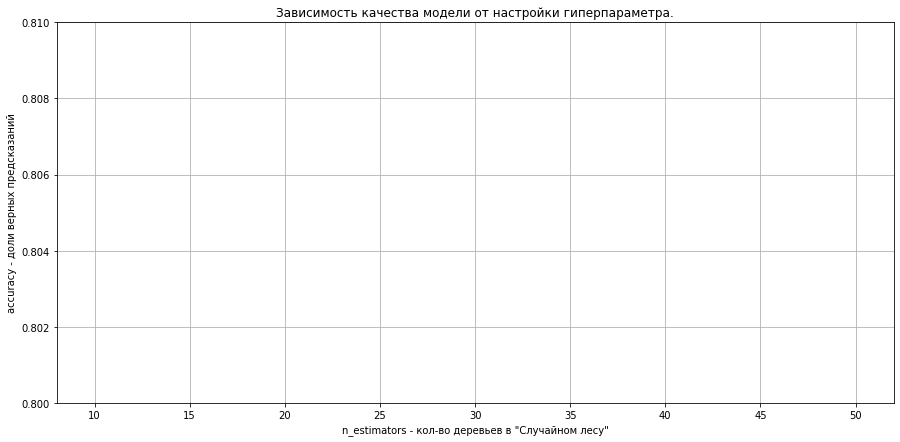

In [44]:
best_est = 0
best_depth = 0
best_accuracy = 0
list_est = []
list_accurasy = []

for est in tqdm(range(10, 51, 10)):
    for depth in range(1, 10):
        model = RandomForestClassifier(max_depth=depth, n_estimators=est, random_state=RANDOM_STATE)
        model.fit(X_train, y_train)
        valid_prediction = model.predict(X_valid)
        valid_accuracy = accuracy_score(y_valid, valid_prediction)
        if valid_accuracy > best_accuracy:
            best_accuracy = valid_accuracy
            best_depth = depth
            best_est = est
    list_est.append(est)
    list_accurasy.append(best_accuracy)

print(f'\n Максимальная оценка модели: {best_accuracy}, при кол-ве деревьев: {best_est}, и их глубине: {best_depth}')


# Визуализация зависимости качества модели от изменения гиперпараметра
accurasy_data = pd.DataFrame({'est': list_est, 'accuracy': list_accurasy})
accurasy_data.plot(style='o-', x='est', y='accuracy', grid=True, legend=False, figsize=(15, 7), ylim=(0.80, 0.81),
                   title='Зависимость качества модели от настройки гиперпараметра.',
                   xlabel='n_estimators - кол-во деревьев в "Случайном лесу"',
                   ylabel='accuracy - доли верных предсказаний')
plt.show()

In [46]:
model = RandomForestClassifier(max_depth=1, n_estimators=10, random_state=RANDOM_STATE)
model.fit(X_train, y_train)
valid_prediction = model.predict(X_valid)
valid_accuracy = accuracy_score(y_valid, valid_prediction)

print(f'\n Максимальная оценка модели: {valid_accuracy}')


 Максимальная оценка модели: 0.9798203333333333


In [48]:
valid_probabilities = model.predict_proba(X_valid)[:, 1]

Проведем поиск 5 наиболее подходящих кандидатов для сопоставления.

In [49]:
valid_proba_series = pd.Series(valid_probabilities)

valid_candidates = []
for i in range(0, len(valid_proba_series), K_NEIGHBORS):
    query = valid_proba_series[i : i+K_NEIGHBORS]
    index = query.sort_values(ascending=False)[0:N_CELLS].index
    valid_candidates.append(index)

# контроль
print('Кол-во предсказаний:', len(valid_candidates))
print('Кол-во кандидатов:', len(valid_candidates[0]))

Кол-во предсказаний: 100000
Кол-во кандидатов: 5


Оценка качества модели.

In [50]:

acc = 0
for target, candidates in zip(valid_targets.values.tolist(), valid_candidates):
    acc += int(target in valid_base_df.loc[candidates, 'id_candidate'].values)

print('valid_accuracy@{}: {:.2f}%'.format(N_CELLS, acc / len(valid_candidates) * 100))

valid_accuracy@5: 21.13%


# Логистическая регрессия

valid_accuracy: 60.02%
Wall time: 1min 41s


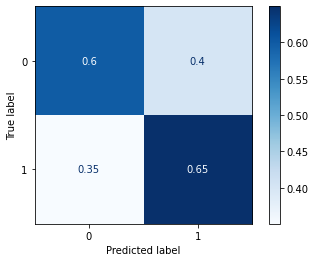

In [51]:
%%time

model = LogisticRegression(solver='lbfgs', class_weight='balanced', random_state=RANDOM_STATE)

model.fit(X_train.values, y_train)

valid_predictions = model.predict(X_valid)
valid_probabilities = model.predict_proba(X_valid)[:, 1]
valid_accuracy = accuracy_score(y_valid, valid_predictions)

print('valid_accuracy: {:.2%}'.format(valid_accuracy))
ConfusionMatrixDisplay.from_predictions(y_valid, valid_predictions, normalize='true', cmap=plt.cm.Blues);

Проведем поиск 5 наиболее подходящих кандидатов для сопоставления.

In [52]:
valid_proba_series = pd.Series(valid_probabilities)

valid_candidates = []
for i in range(0, len(valid_proba_series), K_NEIGHBORS):
    query = valid_proba_series[i : i+K_NEIGHBORS]
    index = query.sort_values(ascending=False)[0:N_CELLS].index
    valid_candidates.append(index)

# контроль
print('Кол-во предсказаний:', len(valid_candidates))
print('Кол-во кандидатов:  ', len(valid_candidates[0]))

Кол-во предсказаний: 100000
Кол-во кандидатов:   5


Оценка качества модели.

In [53]:
acc = 0
for target, candidates in zip(valid_targets.values.tolist(), valid_candidates):
    acc += int(target in valid_base_df.loc[candidates, 'id_candidate'].values)

print('valid_accuracy@{}: {:.2%}'.format(N_CELLS, acc / len(valid_candidates)))

valid_accuracy@5: 17.15%


# Модель CatBoost

In [88]:
model = CatBoostClassifier(verbose=500, depth=6, 
                           iterations=1500, 
                           random_seed=42, 
                           loss_function='Logloss',
                           boosting_type='Ordered')
model.fit(X_train, y_train)

Learning rate set to 0.216865
0:	learn: 0.3753114	total: 11.7s	remaining: 4h 52m 32s
500:	learn: 0.0234917	total: 1h 36m 3s	remaining: 3h 11m 32s
1000:	learn: 0.0206907	total: 2h 31m	remaining: 1h 15m 16s
1499:	learn: 0.0203181	total: 3h 1m 28s	remaining: 0us


In [89]:
valid_prediction = model.predict(X_valid)
valid_accuracy = accuracy_score(y_valid, valid_prediction)
valid_probabilities = model.predict_proba(X_valid)[:, 1]
print(f'\n Максимальная оценка модели: {valid_accuracy}')


 Максимальная оценка модели: 0.9925713333333334


Проведем поиск 5 наиболее подходящих кандидатов для сопоставления.

In [90]:
valid_proba_series = pd.Series(valid_probabilities)

valid_candidates = []
for i in range(0, len(valid_proba_series), K_NEIGHBORS):
    query = valid_proba_series[i : i+K_NEIGHBORS]
    index = query.sort_values(ascending=False)[0:N_CELLS].index
    valid_candidates.append(index)

# контроль
print('Кол-во предсказаний:', len(valid_candidates))
print('Кол-во кандидатов:', len(valid_candidates[0]))

Кол-во предсказаний: 100000
Кол-во кандидатов: 5


Оценка качества модели.

In [91]:
acc = 0
for target, candidates in zip(valid_targets.values.tolist(), valid_candidates):
    acc += int(target in valid_base_df.loc[candidates, 'id_candidate'].values)

print('valid_accuracy@{}: {:.2%}'.format(N_CELLS, acc / len(valid_candidates)))

valid_accuracy@5: 59.50%


# Основные выводы

По результатам оценки датасета установлено, что данные имеют хорошее качество. Пропуски, дубликаты, выбросы / аномалии - отсутствуют. Большинство данных имеют распределение близкое к нормальному. Также имеются аномалии в столбцах №№ `6, 21, 25, 33, 44, 59, 65, 70`.


Поскольку значения признаков сильно отличаются друг от друга все признаки были отмасштабированы. Это помогло сделать их равнозначными и находить объективные закономерности в дальнейшем.

Было создано и наполнено векторное пространство из объектов датасета `base`. Пространство поделено на 20 кластеров, что ускоряет и уточняет процесс поиска. Для каждого объекта из `train` были найдены 20 ближайших векторов при помощи меры `FlatL2`. Упомянутые числовые параметры были подобраны эмпирическим путём, при этом опыты с трёхзначными числами не проводились.


Проведена проверка поиска 5 наиболее подходящих кандидатов с помощью трех обкченных моделей. Модель логистической регрессии показала наихудший результат, с показателем метрики в 17%. Модель случайного дерева показала результат в 21%. Наилучший результат показала модель CatBoost, итоговое значение целевой метрики 59,5%. Но обучение модели составило около 5 часов.